# Extract the MS2 scan and do signature neutral loss search
- run multiple files
- need to define a precursor target list & scan range (let's just try to do more inclusive one)

In [1]:
# !pip install pymzml
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pymzml
import os
import pandas as pd
import sys

In [3]:
sys.path.append('../pyutils/')  # add the second parent directory
from searchMS2 import *

In [4]:
# spectrum.selected_precursors
# [{'mz': 417.320373535156, 'charge': 1, 'precursor id': '2'}]

In [5]:
dir_path = "../../../../MS_MS_raw_mzML/AX_RPneg_pooled/mzML/"
files_and_dirs = os.listdir(dir_path)

# Get the full path for each file/directory in the list
infiles = [os.path.join(dir_path, file) for file in files_and_dirs]

In [6]:
exps = []
for infile in infiles:
    exps.append(pymzml.run.Reader(infile))

[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False


## Basic information - using the first instance

In [7]:
exp = pymzml.run.Reader(infiles[0])

[Warning] Not index found and build_index_from_scratch is False


In [8]:
# How many spectra
exp.get_spectrum_count()

4040

In [9]:
exp.ms_precisions # ms-level 1: ppm 5; ms-level 2: ppm 20?

{None: 0.0001, 0: 0.0001, 1: 5e-06, 2: 2e-05}

##### summary
- a probably 12 min run (720 secs) for 4008 scans
- 0.17964 second/scan

## Load target list

In [10]:
df_sel = pd.read_csv("./data/input/PS_sel_one_wayANOVA_hMinImp_TICnorm_groupFil0.3_RPneg_fullreport.csv")

In [11]:
df_sel.head(10)

,id_number,X.M.H.,Species.Shorthand,Formula,Neutral_Mass,Common.Name,gMean_Tn,gMean_CD8stem,gMean_CD8trans,gMean_CD8TD,...,CD8TD_750K_2,CD8stem_250K_1,CD8stem_300K_2,CD8trans_250K_2,CD8trans_350K_1,Tn_250K_1,Tn_250K_2,pooled_1,pooled_2,pooled_3
0,F10088,706.502297,PS O-31:0,C37H74NO9P,707.510122,PS(O-16:0/15:0);PS(O-18:0/13:0),22.549751,22.242303,22.232876,21.812267,...,21.861243,22.152181,22.332425,22.055728,22.410025,22.475036,22.624466,22.230003,22.068929,21.666248
1,F10378,798.528512,PS 37:3,C43H78NO10P,799.536337,"PS(15:1(9Z)/22:2(13Z,16Z));PS(17:0/20:3(8Z,11Z...",19.066357,19.480941,18.380499,17.411911,...,17.734583,19.498693,19.463189,18.763825,17.997173,19.024778,19.107937,18.589737,19.042832,19.354318
2,F10486,734.533597,PS O-33:0,C39H78NO9P,735.541422,PS(O-18:0/15:0);PS(O-20:0/13:0);PS(O-16:0/17:0),21.706523,21.279732,21.175544,20.713135,...,20.925492,21.168424,21.391040,21.140276,21.210811,21.643647,21.769398,21.347664,20.933037,20.733745
3,F11304,768.517947,PS O-36:4,C42H76NO9P,769.525772,"PS(O-18:0/18:4(6Z,9Z,12Z,15Z));PS(P-16:0/20:3(...",18.886893,20.004130,19.687705,19.779775,...,20.672657,19.811251,20.197009,18.886893,20.488517,18.886893,18.886893,18.886893,19.886893,18.886893
4,F11498,810.528512,PS 38:4,C44H78NO10P,811.536337,"PS(18:0/20:4(5Z,8Z,11Z,14Z));PS(18:1(9Z)/20:3(...",22.049175,21.300513,22.905330,21.104791,...,19.409560,23.191467,19.409560,22.334885,23.475775,22.150570,21.947780,22.467774,22.550826,22.760855
5,F11849,772.549247,PS O-36:2,C42H80NO9P,773.557072,"PS(O-16:0/20:2(11Z,14Z));PS(O-18:0/18:2(9Z,12Z...",20.942226,20.161113,20.799373,21.358750,...,21.089358,19.571862,20.750363,20.770753,20.827993,20.836984,21.047469,20.782791,20.879800,20.679221
6,F12641,820.512862,PS 39:6,C45H76NO10P,821.520687,"PS(17:2(9Z,12Z)/22:4(7Z,10Z,13Z,16Z));PS(19:1(...",17.989310,16.205507,16.205507,17.968259,...,18.079150,16.205507,16.205507,16.205507,16.205507,16.205507,19.773114,16.205507,16.205507,16.205507
7,F12819,748.512862,PS 33:0,C39H76NO10P,749.520687,PS(12:0/21:0);PS(14:0/19:0);PS(17:0/16:0);PS(1...,21.203391,21.051978,21.142438,21.489608,...,21.456554,20.969946,21.134011,21.167606,21.117271,21.116658,21.290124,20.891109,21.120224,21.151597
8,F12928,784.549247,PS O-37:3,C43H80NO9P,785.557072,"PS(P-20:0/17:2(9Z,12Z))",20.746608,20.956093,21.196232,18.436286,...,16.436858,20.920069,20.992116,21.467303,20.925160,20.476788,21.016427,20.275338,20.525621,20.706260
9,F13113,832.512862,PS 40:7,C46H76NO10P,833.520687,"PS(18:1(9Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z));PS(18...",20.891264,19.156494,19.156494,21.289901,...,21.509898,19.156494,19.156494,19.156494,19.156494,20.883350,20.899179,21.622607,20.944407,20.149087


In [12]:
FTIDs = df_sel['id_number'].tolist()

In [13]:
df_feat_annot = pd.read_csv("../../../../asari-output-RPneg/output_asari_project_31312361/Feature_annotation.tsv",
                           sep = '\t', index_col=0)

In [14]:
# Select the desired rows and columns from the DataFrame
subset = df_feat_annot.loc[FTIDs, ['mz', 'rtime', 'apex(scan number)']]
# drop duplicates
subset_dd = subset.drop_duplicates() 
# Convert the subset to a dictionary with row-wise orientation
target_dict = subset_dd.to_dict(orient='index')

In [15]:
target_dict

{'F10088': {'mz': 706.5006714,
  'rtime': 376.5235142,
  'apex(scan number)': 1736},
 'F10378': {'mz': 798.5261841,
  'rtime': 343.4068623,
  'apex(scan number)': 1576},
 'F10486': {'mz': 734.531517, 'rtime': 414.8943499, 'apex(scan number)': 1917},
 'F11304': {'mz': 768.5214996, 'rtime': 22.23502574, 'apex(scan number)': 98},
 'F11498': {'mz': 810.5288544, 'rtime': 29.18410728, 'apex(scan number)': 130},
 'F11849': {'mz': 772.5473633,
  'rtime': 326.2512226,
  'apex(scan number)': 1493},
 'F12641': {'mz': 820.513134, 'rtime': 305.2302092, 'apex(scan number)': 1393},
 'F12819': {'mz': 748.5130005, 'rtime': 176.9801149, 'apex(scan number)': 789},
 'F12928': {'mz': 784.548584, 'rtime': 444.1771317, 'apex(scan number)': 2057},
 'F13113': {'mz': 832.5114441,
  'rtime': 306.8813714,
  'apex(scan number)': 1401},
 'F13352': {'mz': 788.5444641,
  'rtime': 303.1665999,
  'apex(scan number)': 1383},
 'F13368': {'mz': 788.57901, 'rtime': 373.2147096, 'apex(scan number)': 1720},
 'F13395': {'mz':

In [16]:
list(target_dict.items())[0]

('F10088',
 {'mz': 706.5006714, 'rtime': 376.5235142, 'apex(scan number)': 1736})

## get potential precursor from multiple files

In [17]:
res_dict = {}
for exp in exps:
    for k,v in target_dict.items():
        spectra = get_potental_precursor_from_exp(exp, 
                              min_scan_number = v['apex(scan number)']-1000, 
                              max_scan_number = v['apex(scan number)']+1000, 
                              min_mz = np.floor(v['mz']), 
                              max_mz = np.ceil(v['mz']), 
                              ms_level=2)
        res_dict[k] = spectra

[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_inde

In [18]:
res_dict

{'F10088': [<__main__.Spectrum object with native ID 1048 at 0x7f8dfc50ffd0>,
  <__main__.Spectrum object with native ID 1050 at 0x7f8dfb1787f0>,
  <__main__.Spectrum object with native ID 1254 at 0x7f8dfb167f10>,
  <__main__.Spectrum object with native ID 1256 at 0x7f8dfb167e80>,
  <__main__.Spectrum object with native ID 1294 at 0x7f8dfb1a61c0>,
  <__main__.Spectrum object with native ID 1296 at 0x7f8dfb167070>,
  <__main__.Spectrum object with native ID 1379 at 0x7f8dfb14e880>,
  <__main__.Spectrum object with native ID 1381 at 0x7f8dfb178910>],
 'F10378': [],
 'F10486': [<__main__.Spectrum object with native ID 1144 at 0x7f8dfb18d7c0>,
  <__main__.Spectrum object with native ID 1146 at 0x7f8dfb21c820>,
  <__main__.Spectrum object with native ID 1163 at 0x7f8dfb18d220>,
  <__main__.Spectrum object with native ID 1165 at 0x7f8dfb178e50>,
  <__main__.Spectrum object with native ID 1183 at 0x7f8dfb14e760>,
  <__main__.Spectrum object with native ID 1185 at 0x7f8dfb14ebb0>,
  <__main__.

In [19]:
# items that don't have spectra associated
[k for k,v in res_dict.items() if len(v) == 0 ]

['F10378',
 'F11304',
 'F11498',
 'F11849',
 'F12928',
 'F13113',
 'F13352',
 'F13368',
 'F13395',
 'F13804',
 'F13805',
 'F14097',
 'F14243',
 'F14588',
 'F14998',
 'F15086',
 'F15244',
 'F15491',
 'F15637',
 'F15666',
 'F16120',
 'F16127',
 'F1614',
 'F16286',
 'F16535',
 'F17235',
 'F1779',
 'F3138',
 'F3712',
 'F5983',
 'F7394',
 'F9383',
 'F9458',
 'F9945']

In [20]:
res_dict_clean = {k:v for k,v in res_dict.items() if len(v) != 0}

In [21]:
res_dict_clean

{'F10088': [<__main__.Spectrum object with native ID 1048 at 0x7f8dfc50ffd0>,
  <__main__.Spectrum object with native ID 1050 at 0x7f8dfb1787f0>,
  <__main__.Spectrum object with native ID 1254 at 0x7f8dfb167f10>,
  <__main__.Spectrum object with native ID 1256 at 0x7f8dfb167e80>,
  <__main__.Spectrum object with native ID 1294 at 0x7f8dfb1a61c0>,
  <__main__.Spectrum object with native ID 1296 at 0x7f8dfb167070>,
  <__main__.Spectrum object with native ID 1379 at 0x7f8dfb14e880>,
  <__main__.Spectrum object with native ID 1381 at 0x7f8dfb178910>],
 'F10486': [<__main__.Spectrum object with native ID 1144 at 0x7f8dfb18d7c0>,
  <__main__.Spectrum object with native ID 1146 at 0x7f8dfb21c820>,
  <__main__.Spectrum object with native ID 1163 at 0x7f8dfb18d220>,
  <__main__.Spectrum object with native ID 1165 at 0x7f8dfb178e50>,
  <__main__.Spectrum object with native ID 1183 at 0x7f8dfb14e760>,
  <__main__.Spectrum object with native ID 1185 at 0x7f8dfb14ebb0>,
  <__main__.Spectrum object

In [22]:
# this function only works for situation where you look at charge state = 1
def search_NL(spectra,
              NL_mz = 87.03124,
              ppm = 50):
    res_data = []

    for spec in spectra:
        selected_precursor_mz = spec.selected_precursors[0]['mz'] # this m/z will not be exactly the precursor m/z
        sel_mz = [mz for mz in spec.mz if abs(mz - selected_precursor_mz) < np.ceil(NL_mz)]

        for mz in sel_mz:
            calc_ppm = abs(((selected_precursor_mz - mz) - NL_mz)*1000000/NL_mz)
            if calc_ppm < ppm:
                print(calc_ppm)
                res_data.append(spec)
                break
    return res_data

In [23]:
res_dict = {}
for FTID, spectra in res_dict_clean.items():
    res_dict.update({FTID: search_NL(spectra)})

In [24]:
res_dict

{'F10088': [],
 'F10486': [],
 'F12641': [],
 'F12819': [],
 'F5343': [],
 'F9693': []}

# plot accordingly

In [25]:
res_dict_clean.keys()

dict_keys(['F10088', 'F10486', 'F12641', 'F12819', 'F5343', 'F9693'])

In [26]:
df_sel.index = df_sel['id_number']

In [27]:
df_sel.columns[0:6]

Index(['id_number', 'X.M.H.', 'Species.Shorthand', 'Formula', 'Neutral_Mass',
       'Common.Name'],
      dtype='object')

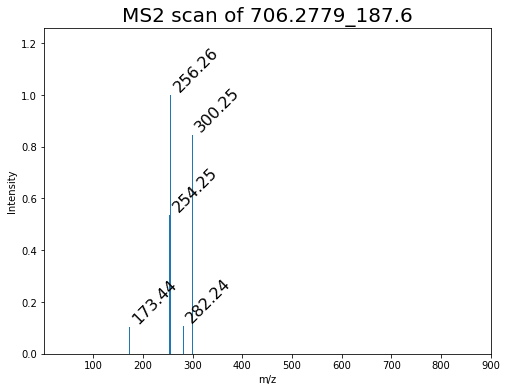

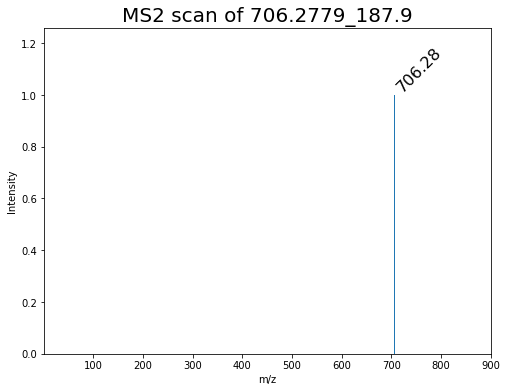

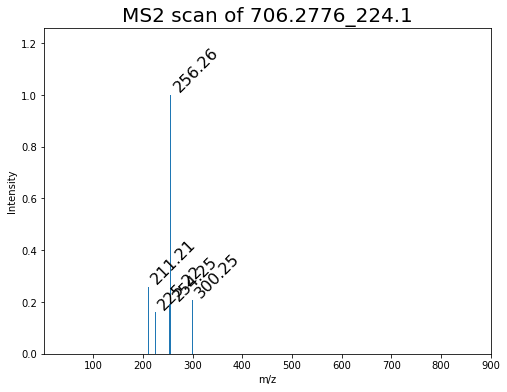

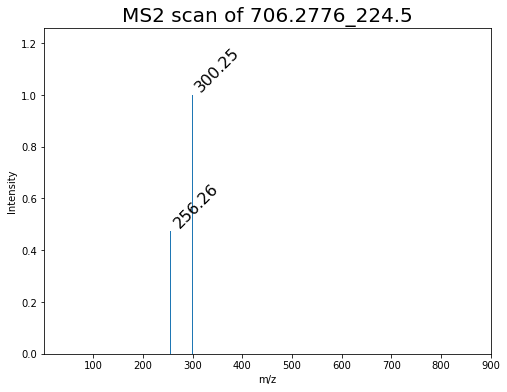

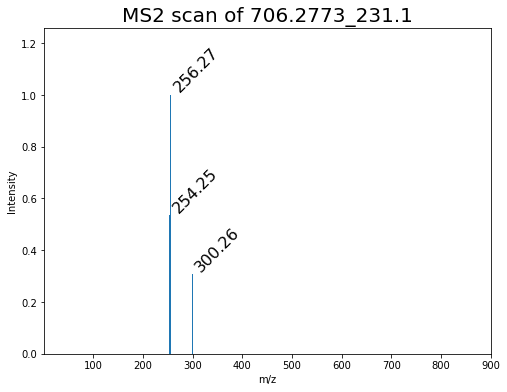

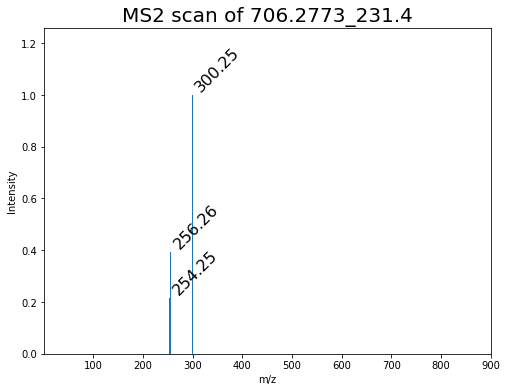

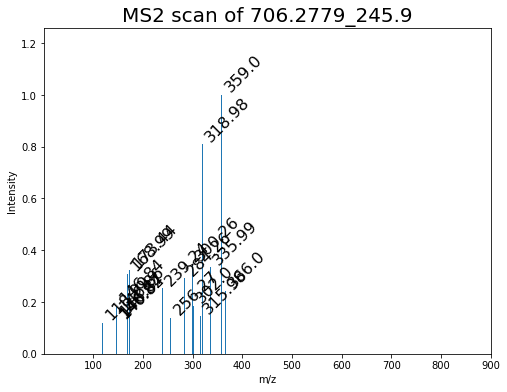

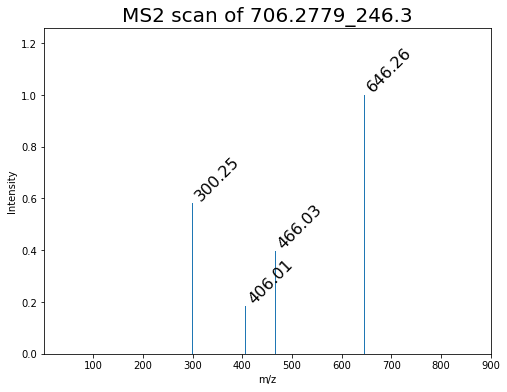

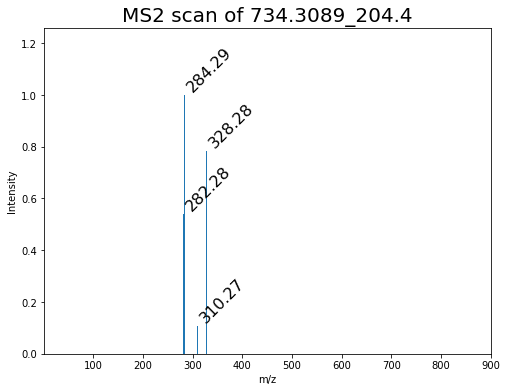

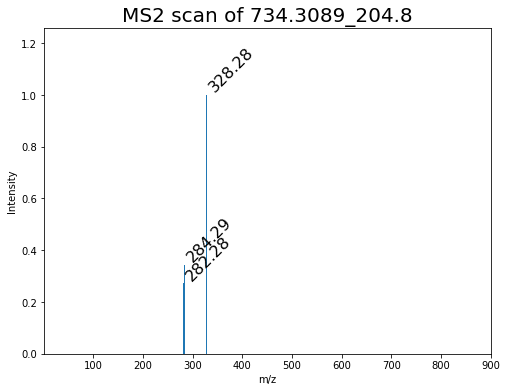

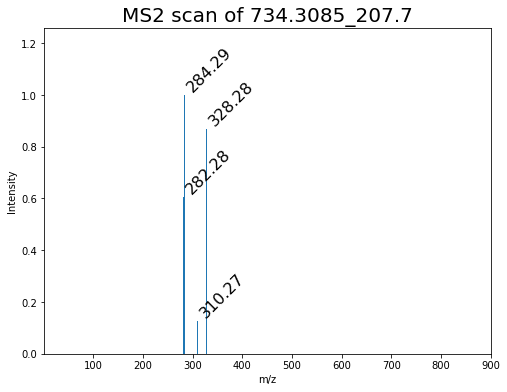

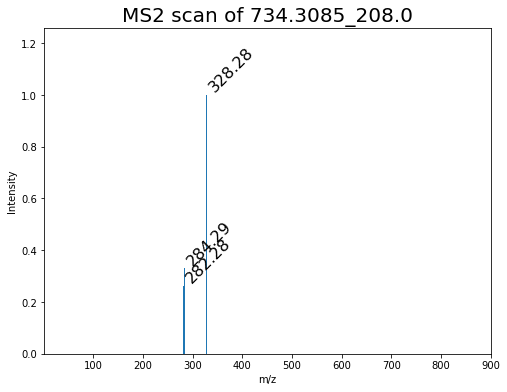

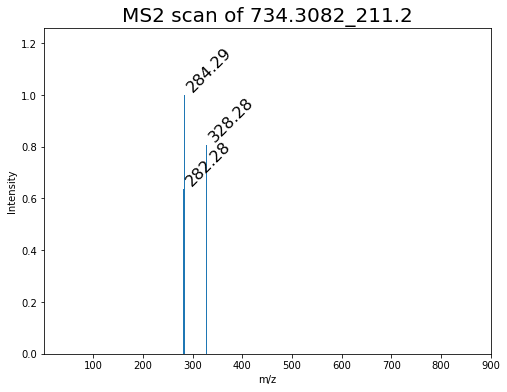

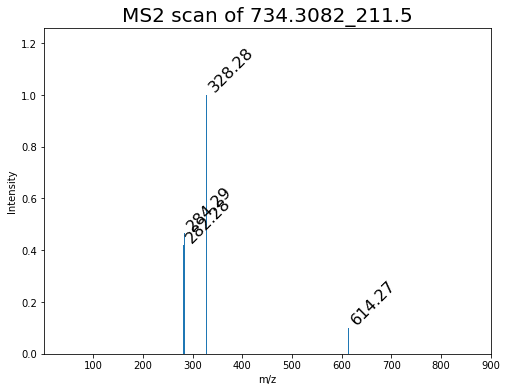

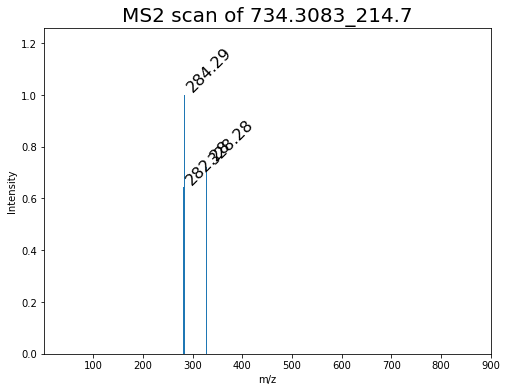

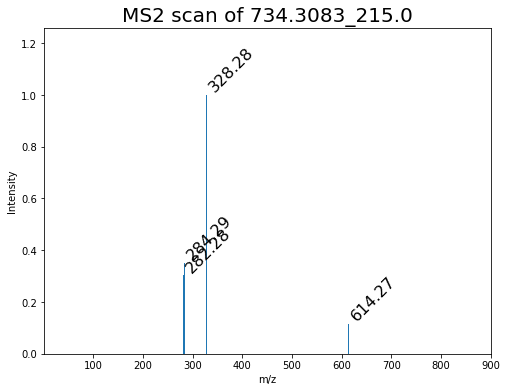

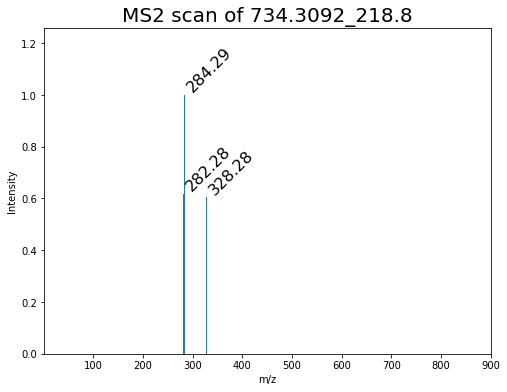

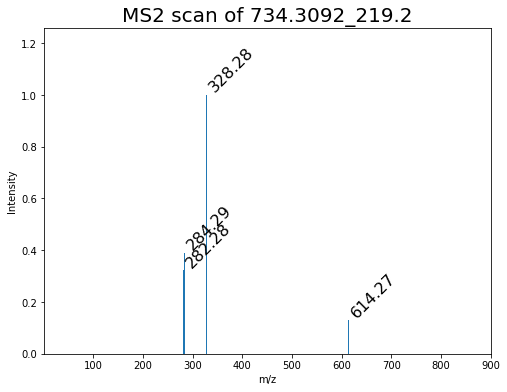

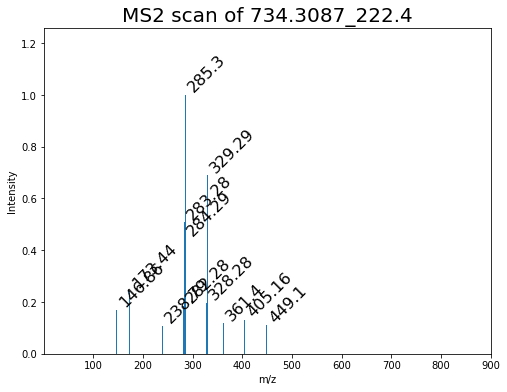

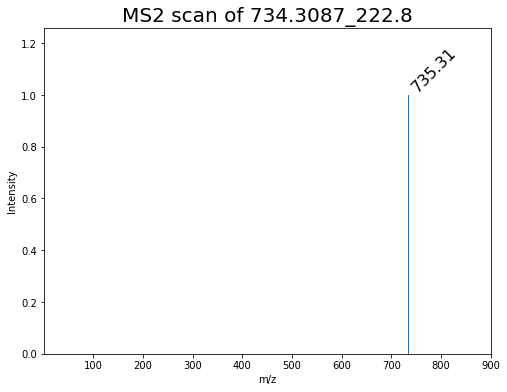

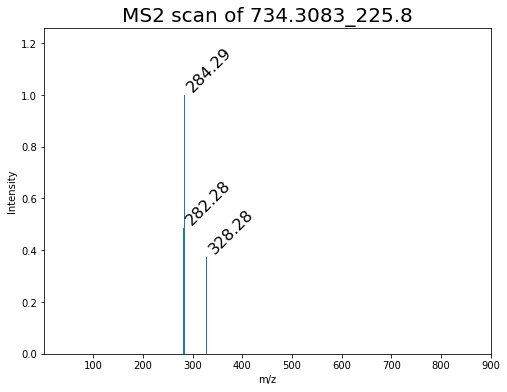

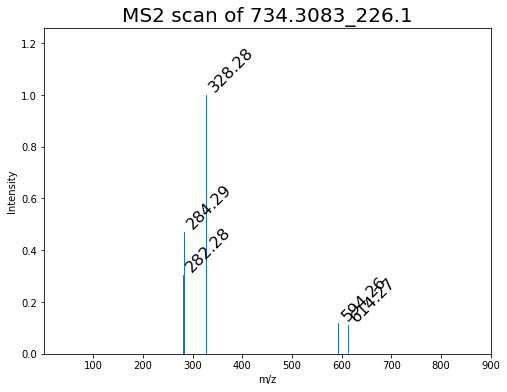

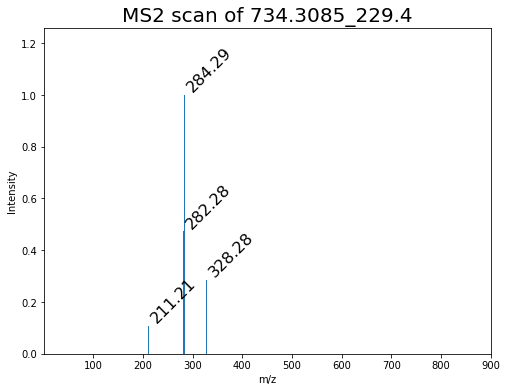

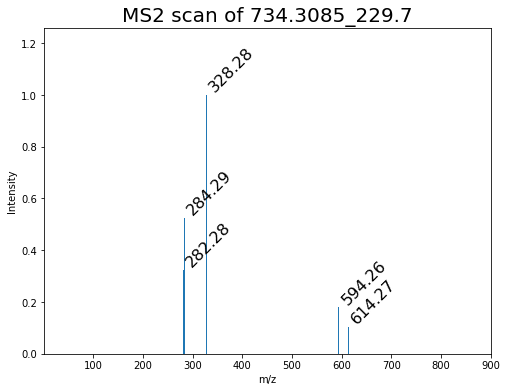

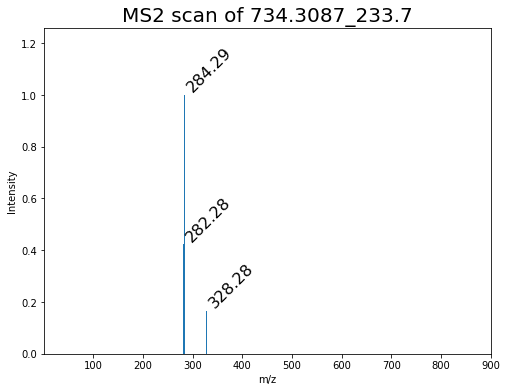

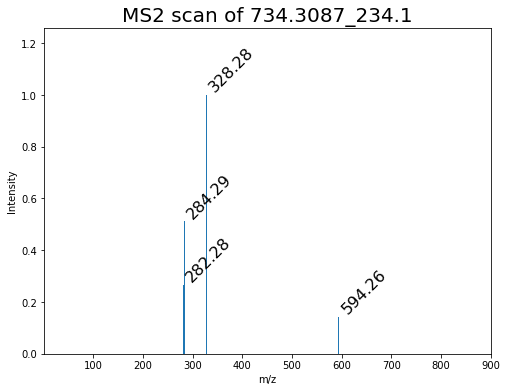

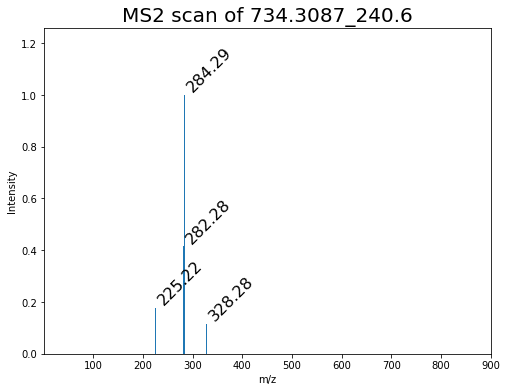

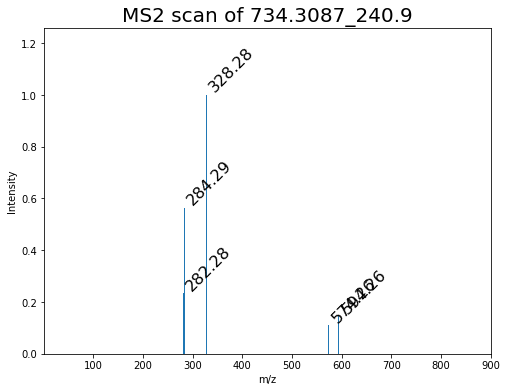

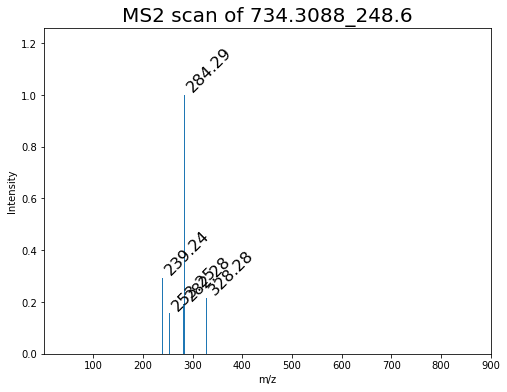

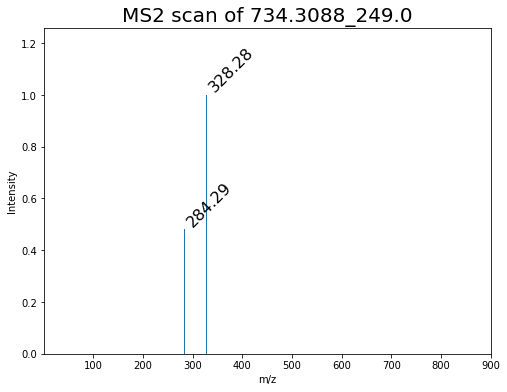

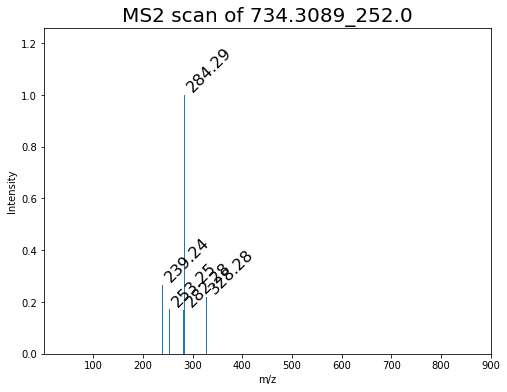

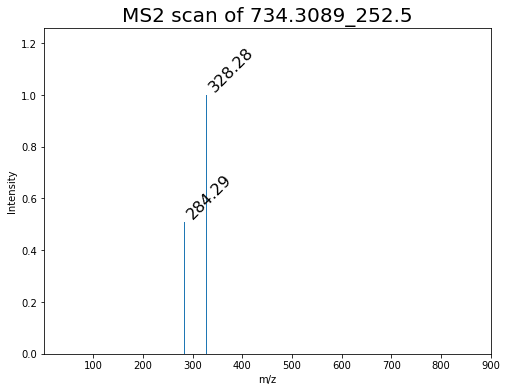

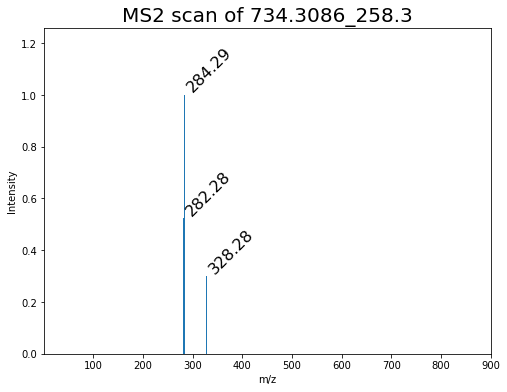

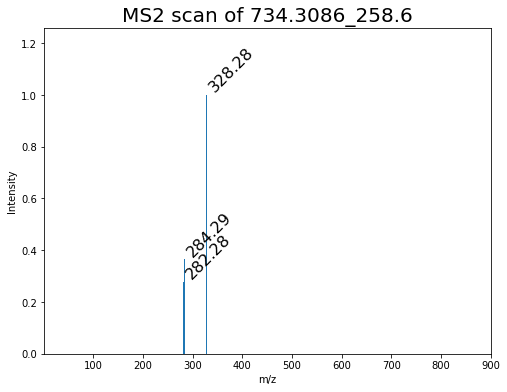

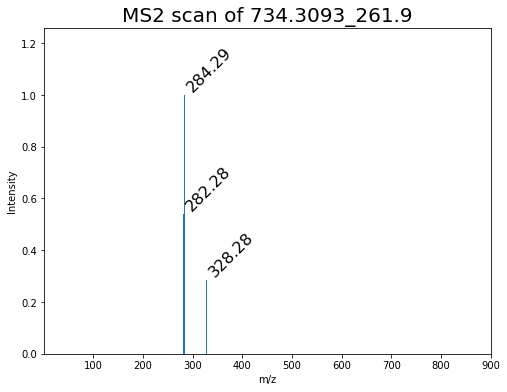

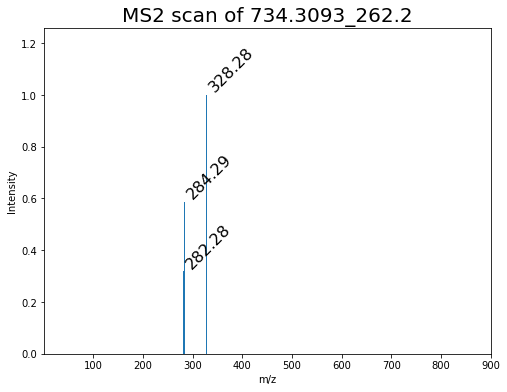

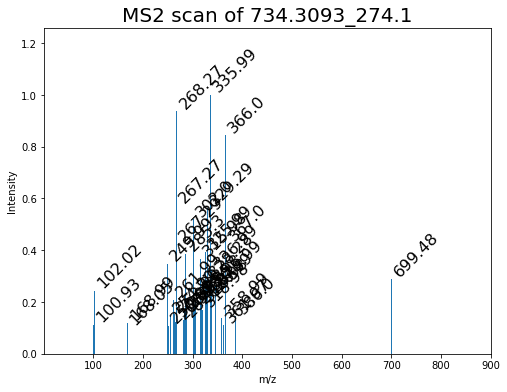

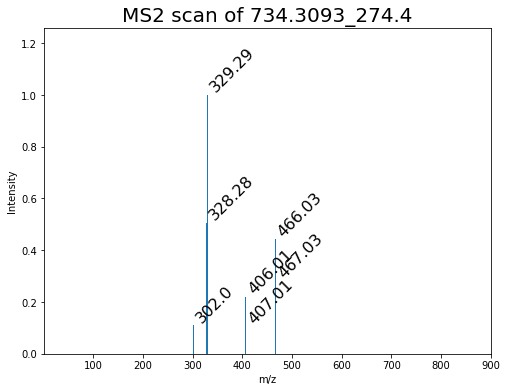

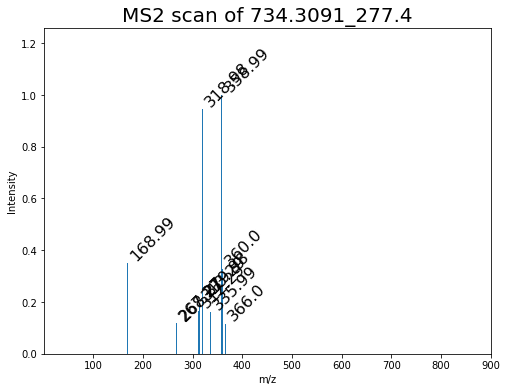

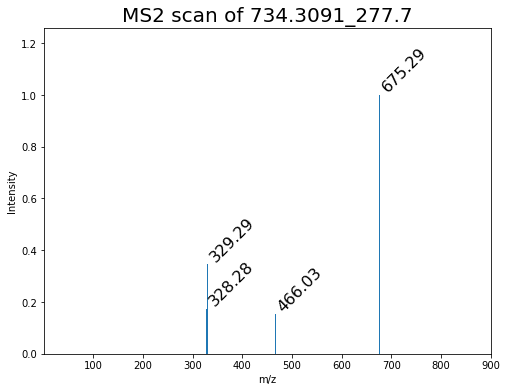

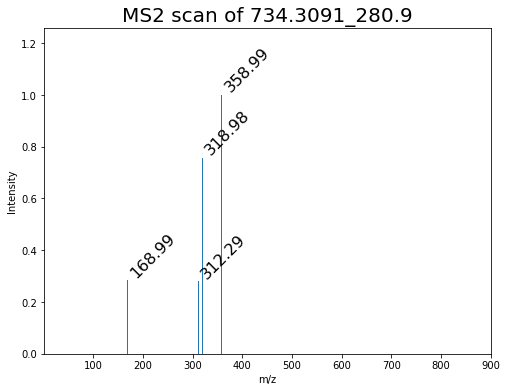

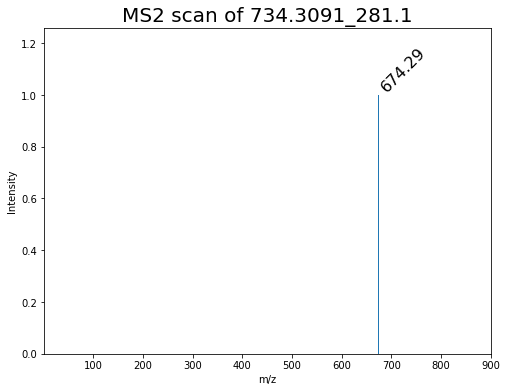

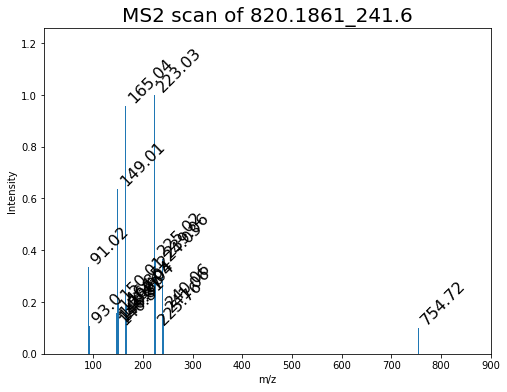

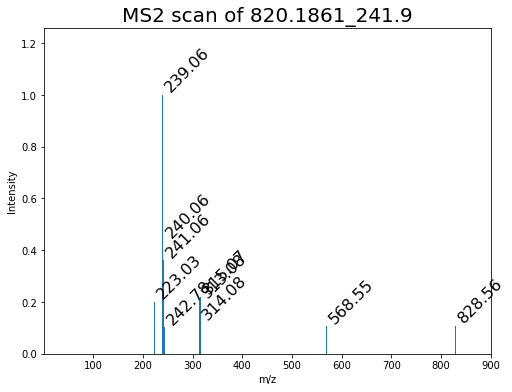

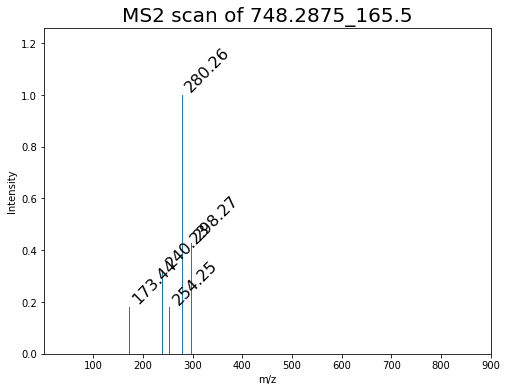

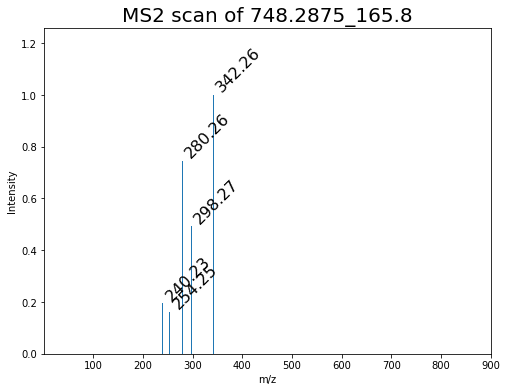

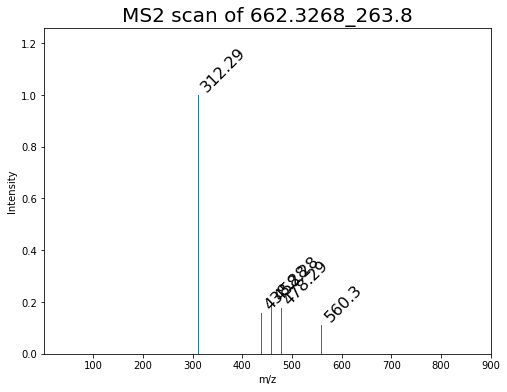

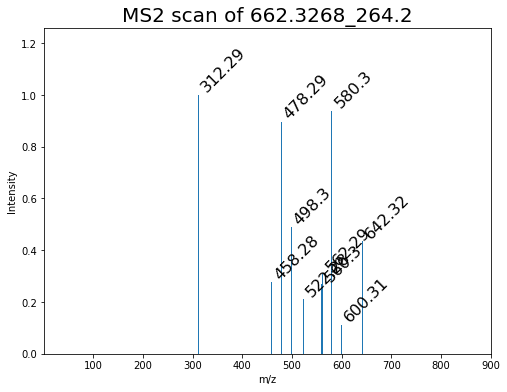

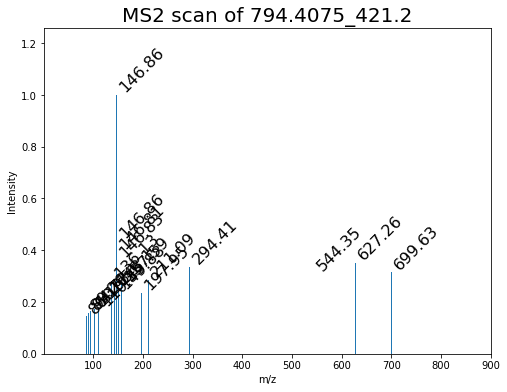

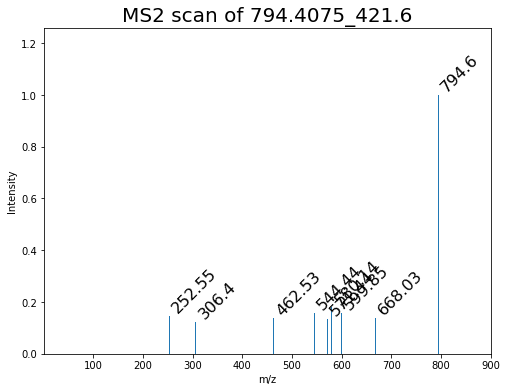

In [29]:
for FTID in res_dict_clean.keys():
    plot_spectra(spectra = res_dict_clean[FTID], 
                 save_figure=True,
                 output_path=f"./data/output/{FTID}_{df_sel.loc[FTID,'Species.Shorthand']}/",
                 label = f"{FTID}_{df_sel.loc[FTID,'Species.Shorthand']}"
                 )